# **< 멋진 작사가 만들기 프로젝트 >**

### Step 1. 데이터 다운로드

In [2]:
import glob
import os, re
import numpy as np
import tensorflow as tf


### Step 2. 데이터 읽어오기

In [3]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 [' There must be some kind of way outta here', 'Said the joker to the thief', "There's too much confusion"]


### Step 3. 데이터 정제

In [4]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue  
    if sentence[-1] == ":": continue 
    if idx > 10: break  
        
    print(sentence)

 There must be some kind of way outta here
Said the joker to the thief
There's too much confusion
I can't get no relief Business men, they drink my wine
Plowman dig my earth
None were level on the mind
Nobody up at his word
Hey, hey No reason to get excited
The thief he kindly spoke
There are many here among us
Who feel that life is but a joke


In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [58]:
corpus = []

for sentence in raw_corpus:
    # 길이가 0인 문장 제외
    if len(sentence) == 0: continue
    # ':'로 끝나는 문장 제외
    if sentence[-1] == ":": continue
#     # '['로 시작해서, ']'로 끝나는 문장 제외(예: [Hook], 파트 구분 등)    
#     if sentence[0] == "[" and sentence[-1] == "]": continue  
#     # '('로 시작해서, ')'로 끝나는 문장 제외(예: (Till now), 코러스 등)
#     if sentence[0] == "(" and sentence[-1] == ")": continue 
    # 문장 전처리        
    preprocessed_sentence = preprocess_sentence(sentence)  
    # 토큰수 15개 이상 제외
    if len(preprocessed_sentence.split(' ')) > 15 : continue 
    # corpus 리스트 추가    
    corpus.append(preprocessed_sentence)

print('corpus 문장 수 :', len(corpus))
corpus[:10]

unique_corpus = list(set(corpus))
print('unique_corpus 문장 수 :', len(unique_corpus))

corpus 문장 수 : 156013
unique_corpus 문장 수 : 100789


In [59]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=12000,
                                                      filters=' ',
                                                      oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post',
                                                           maxlen=15) 
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2  62 271 ...   0   0   0]
 [  2 118   6 ...   0   0   0]
 [  2  62  17 ...   0   0   0]
 ...
 [  2  75  45 ...   3   0   0]
 [  2  49   5 ...   0   0   0]
 [  2  13 633 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fe34519f310>


In [60]:
print(tensor[:3, :])
print(tensor.shape)

[[   2   62  271   27   94  546   20   86  742   90    3    0    0    0
     0]
 [   2  118    6 6263   10    6 2307    3    0    0    0    0    0    0
     0]
 [   2   62   17  102  184 2711    3    0    0    0    0    0    0    0
     0]]
(156013, 15)


In [61]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [62]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  62 271  27  94 546  20  86 742  90   3   0   0   0]
[ 62 271  27  94 546  20  86 742  90   3   0   0   0   0]


### Step 4. 평가 데이터셋 분리

In [63]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.2,
                                                          random_state=24)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Val:", enc_val.shape)
print("Target Val:", dec_val.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)
Source Val: (31203, 14)
Target Val: (31203, 14)


In [64]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

In [65]:
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [66]:
valset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
valset = valset.shuffle(BUFFER_SIZE)
valset = valset.batch(BATCH_SIZE, drop_remainder=True)
valset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

### Step 5. 인공지능 만들기

In [67]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [68]:
class TextGenerator2(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.linear(out)
        
        return out

In [69]:
embedding_size = 256
hidden_size = 1024
#model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
#model2 = TextGenerator(tokenizer.num_words + 1, embedding_size//2 , hidden_size//2)
#model3 = TextGenerator(tokenizer.num_words + 1, embedding_size//4 , hidden_size//4)
#model4 = TextGenerator(tokenizer.num_words + 1, embedding_size*2 , hidden_size*2)
#model5 = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size*2)
#model6 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
#model7 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
#model8 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
model9 = TextGenerator2(tokenizer.num_words + 1, embedding_size , hidden_size)

In [156]:
for enc_train_sample, dec_train_sample in dataset.take(1): break

model(enc_train_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-6.04422858e-05,  1.24441169e-06,  3.53720941e-04, ...,
          1.12211914e-04,  1.43381723e-04, -2.50072015e-04],
        [-9.61631013e-05,  7.65148652e-05,  6.47268374e-04, ...,
          8.47528499e-05,  7.06660503e-05, -3.89943831e-04],
        [ 1.49587300e-04,  8.10018628e-06,  5.92946948e-04, ...,
         -1.15971743e-05,  1.59461342e-04, -3.86121043e-04],
        ...,
        [ 8.78415711e-04, -1.13405846e-03, -5.70510965e-05, ...,
          1.14914495e-03, -1.92104271e-04, -1.62744813e-03],
        [ 8.58943327e-04, -1.55781198e-03,  1.27510255e-04, ...,
          1.42243470e-03, -1.70889194e-04, -2.03823135e-03],
        [ 8.29107070e-04, -1.92884752e-03,  3.37798236e-04, ...,
          1.71931344e-03, -8.15224630e-05, -2.43347045e-03]],

       [[-6.04422858e-05,  1.24441169e-06,  3.53720941e-04, ...,
          1.12211914e-04,  1.43381723e-04, -2.50072015e-04],
        [ 1.37544794e-05, -1.82392650e-05,  4

In [186]:
for enc_train_sample, dec_train_sample in dataset.take(1): break

model2(enc_train_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-9.38127050e-05,  7.04881968e-05,  2.18073728e-05, ...,
         -1.35553448e-04, -1.05880579e-04, -4.60859555e-05],
        [-1.46631806e-04,  1.93812462e-04,  3.07673181e-05, ...,
         -1.18722965e-04, -1.34745220e-04, -1.96592373e-05],
        [-1.71872700e-04,  2.14485612e-04,  1.73483480e-04, ...,
         -9.38697704e-05, -1.30237793e-04,  3.47249102e-06],
        ...,
        [-1.32334302e-03,  1.24437560e-03,  1.33692531e-03, ...,
          2.38947177e-04, -1.05480431e-03,  2.49217381e-03],
        [-1.38476468e-03,  1.37538929e-03,  1.38507201e-03, ...,
          2.20375543e-04, -1.22792786e-03,  2.78897956e-03],
        [-1.39837409e-03,  1.49393210e-03,  1.42668223e-03, ...,
          1.88520149e-04, -1.38447015e-03,  3.04978504e-03]],

       [[-9.38127050e-05,  7.04881968e-05,  2.18073728e-05, ...,
         -1.35553448e-04, -1.05880579e-04, -4.60859555e-05],
        [-1.26610321e-04, -8.07656033e-05,  1

In [193]:
for enc_train_sample, dec_train_sample in dataset.take(1): break

model3(enc_train_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 3.82952821e-05, -4.66298388e-06, -8.88352224e-06, ...,
         -3.13711607e-05,  1.85763531e-06,  3.82947837e-05],
        [-1.64654994e-05, -7.24074707e-05,  8.62810193e-05, ...,
         -8.33917002e-05,  6.15156241e-05,  9.85883162e-05],
        [-8.00311172e-05, -5.09863530e-05,  7.26817016e-05, ...,
         -1.20526514e-04,  1.45247701e-04,  9.61444530e-05],
        ...,
        [ 3.55449563e-04, -1.82933854e-05,  8.39509128e-04, ...,
          1.66854850e-04, -4.41699929e-04, -1.17781135e-04],
        [ 3.91648966e-04, -1.78858245e-05,  9.39563091e-04, ...,
          2.41814982e-04, -7.76467379e-04, -1.97279674e-04],
        [ 4.26387152e-04, -2.11305050e-05,  1.01067603e-03, ...,
          3.26189678e-04, -1.11112336e-03, -2.90260301e-04]],

       [[ 3.82952821e-05, -4.66298388e-06, -8.88352224e-06, ...,
         -3.13711607e-05,  1.85763531e-06,  3.82947837e-05],
        [ 9.61738406e-05, -2.21607450e-04,  9

In [198]:
for enc_train_sample, dec_train_sample in dataset.take(1): break

model4(enc_train_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-2.96528069e-05,  8.35307437e-05,  2.13118998e-04, ...,
          3.03366774e-04,  3.19154526e-04, -2.51131773e-04],
        [-5.50792101e-05, -1.76079790e-04,  3.48727772e-04, ...,
          1.02979633e-04,  6.12709788e-04, -7.16233219e-04],
        [-3.07094684e-04, -3.08099581e-04,  3.90902977e-04, ...,
         -7.07608779e-05,  9.35108692e-04, -5.37855318e-04],
        ...,
        [-1.67677272e-03, -1.18175312e-03,  8.10321420e-04, ...,
         -7.84337812e-04, -1.50576548e-03,  3.13360477e-04],
        [-2.10742140e-03, -1.21830869e-03,  6.03921653e-04, ...,
         -1.02516776e-03, -1.87078549e-03,  5.67944953e-04],
        [-2.48718332e-03, -1.21475616e-03,  3.52980132e-04, ...,
         -1.23270112e-03, -2.12069531e-03,  8.15443695e-04]],

       [[-2.96528069e-05,  8.35307437e-05,  2.13118998e-04, ...,
          3.03366774e-04,  3.19154526e-04, -2.51131773e-04],
        [ 4.36011978e-05,  8.20801943e-05,  1

In [203]:
for enc_train_sample, dec_train_sample in dataset.take(1): break

model5(enc_train_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-1.02299873e-05, -1.29380584e-04, -4.23697820e-05, ...,
          1.62502096e-04,  1.60761891e-04, -1.51823770e-04],
        [ 8.41956789e-05, -9.78946628e-05, -2.83584232e-04, ...,
          1.50756328e-04,  1.23126199e-04, -3.07363545e-04],
        [ 1.49015264e-04,  2.33015562e-05, -5.60626388e-04, ...,
          2.41027330e-04, -9.15125565e-05, -4.15166200e-04],
        ...,
        [ 7.65852921e-04, -1.33984955e-03, -1.20362849e-03, ...,
         -4.88326827e-04, -1.21484627e-03,  1.90517603e-04],
        [ 8.95716599e-04, -1.22300338e-03, -1.06787926e-03, ...,
         -6.48948306e-04, -1.65349396e-03,  6.07377558e-04],
        [ 9.71071713e-04, -1.01482403e-03, -9.45136242e-04, ...,
         -7.92516570e-04, -2.02395720e-03,  9.84841026e-04]],

       [[-1.02299873e-05, -1.29380584e-04, -4.23697820e-05, ...,
          1.62502096e-04,  1.60761891e-04, -1.51823770e-04],
        [ 2.14582560e-05, -4.64469085e-05, -1

In [14]:
for enc_train_sample, dec_train_sample in dataset.take(1): break

model6(enc_train_sample)

<tf.Tensor: shape=(128, 14, 12001), dtype=float32, numpy=
array([[[-1.22949728e-04,  1.34205300e-04,  2.76273367e-05, ...,
         -3.25922265e-05, -1.97779678e-04,  4.11048604e-05],
        [-4.64433688e-05,  8.61790613e-05, -5.38183740e-05, ...,
         -3.00920565e-05, -3.50019487e-04,  9.41237886e-05],
        [ 1.90271254e-04, -1.56902170e-04,  5.17698063e-05, ...,
         -1.36121889e-04, -4.31854598e-04,  2.57985812e-04],
        ...,
        [ 8.31506040e-04,  1.14480026e-04, -1.10628745e-04, ...,
         -5.33429615e-04, -8.94182740e-05,  4.19530370e-05],
        [ 6.12820382e-04,  3.21909320e-04, -3.42792890e-04, ...,
         -4.38645948e-04,  2.52267346e-04, -1.47048893e-04],
        [ 1.58890412e-04,  2.28929246e-04, -3.90456175e-04, ...,
         -4.06642735e-04,  2.16748100e-04, -2.57151958e-04]],

       [[-1.22949728e-04,  1.34205300e-04,  2.76273367e-05, ...,
         -3.25922265e-05, -1.97779678e-04,  4.11048604e-05],
        [-1.50028398e-04,  2.40415015e-04,  2

In [23]:
for enc_train_sample, dec_train_sample in dataset.take(1): break

model7(enc_train_sample)

<tf.Tensor: shape=(128, 14, 12001), dtype=float32, numpy=
array([[[-4.23894031e-04,  7.19143427e-05, -6.14010860e-05, ...,
         -5.92796750e-05, -1.53159184e-04, -1.02608799e-04],
        [-5.28052915e-04,  2.29563288e-04, -3.07037611e-04, ...,
         -1.55110727e-04, -6.01810229e-04, -9.78444514e-05],
        [-5.93802251e-04,  2.90416647e-04, -5.59238892e-04, ...,
         -3.31964460e-04, -8.73725396e-04, -1.49646003e-04],
        ...,
        [-3.18057276e-03,  1.01030490e-03, -7.76802772e-05, ...,
          2.07319716e-03, -1.60994893e-03,  2.46941834e-03],
        [-3.52525641e-03,  1.02867209e-03, -8.51340155e-05, ...,
          2.16569356e-03, -1.77244027e-03,  2.63642450e-03],
        [-3.83905484e-03,  1.04719680e-03, -9.68556706e-05, ...,
          2.20824522e-03, -1.91832788e-03,  2.78400234e-03]],

       [[-4.23894031e-04,  7.19143427e-05, -6.14010860e-05, ...,
         -5.92796750e-05, -1.53159184e-04, -1.02608799e-04],
        [-9.21739207e-04,  2.54475512e-04, -1

In [31]:
for enc_train_sample, dec_train_sample in dataset.take(1): break

model8(enc_train_sample)

<tf.Tensor: shape=(128, 14, 12001), dtype=float32, numpy=
array([[[ 3.83149018e-05, -3.42109779e-05,  1.25894701e-04, ...,
          7.99960908e-05,  5.04064531e-07,  2.01682633e-04],
        [-4.31316475e-05,  1.49273328e-05,  1.26747997e-04, ...,
          4.65238663e-05, -3.25326182e-05,  2.09985767e-04],
        [-5.70910061e-06,  2.30354253e-05,  1.90459221e-04, ...,
          2.45010888e-04, -3.98082375e-05,  2.84550886e-04],
        ...,
        [ 6.95277588e-04, -4.36848262e-04,  5.64089860e-05, ...,
         -7.66005192e-04,  1.24020240e-04, -2.96026294e-04],
        [ 7.64281373e-04, -3.94435076e-04, -2.24126066e-04, ...,
         -7.59925228e-04,  1.42659934e-04, -4.30458895e-04],
        [ 8.22075061e-04, -2.68373144e-04, -4.90058155e-04, ...,
         -7.13935762e-04,  1.61782023e-04, -4.71473060e-04]],

       [[ 3.83149018e-05, -3.42109779e-05,  1.25894701e-04, ...,
          7.99960908e-05,  5.04064531e-07,  2.01682633e-04],
        [ 1.92750304e-04, -3.03605542e-04, -2

In [70]:
for enc_train_sample, dec_train_sample in dataset.take(1): break

model9(enc_train_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-5.67577314e-04,  8.80789652e-04,  4.08901920e-04, ...,
         -8.39740678e-04,  2.07448174e-04,  5.08524499e-06],
        [-6.99604338e-04, -2.19290494e-04, -4.62465454e-04, ...,
         -7.30441243e-04,  3.51415889e-04, -6.87167922e-05],
        [ 1.65590004e-03, -7.18922704e-04,  1.54037960e-03, ...,
         -2.55929190e-03, -2.22951337e-03, -9.53498511e-06],
        ...,
        [-1.47897610e-03, -2.21534909e-04, -8.73598387e-04, ...,
         -9.49128822e-04, -7.82267889e-04,  1.43418054e-03],
        [-1.41061121e-03, -2.32674211e-05,  2.09844948e-04, ...,
         -1.00969092e-03, -1.32739451e-03,  1.42019405e-03],
        [-3.27204412e-04, -6.23783271e-04,  8.32474325e-04, ...,
         -4.82206116e-04,  1.46133418e-04,  1.53187593e-03]],

       [[-5.67577314e-04,  8.80789652e-04,  4.08901920e-04, ...,
         -8.39740678e-04,  2.07448174e-04,  5.08524499e-06],
        [ 5.83970221e-04, -4.72261192e-04,  1

In [160]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_1 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [187]:
model2.summary()

Model: "text_generator_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      multiple                  1536128   
_________________________________________________________________
lstm_14 (LSTM)               multiple                  1312768   
_________________________________________________________________
lstm_15 (LSTM)               multiple                  2099200   
_________________________________________________________________
dense_7 (Dense)              multiple                  6156513   
Total params: 11,104,609
Trainable params: 11,104,609
Non-trainable params: 0
_________________________________________________________________


In [194]:
model3.summary()

Model: "text_generator_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  768064    
_________________________________________________________________
lstm_20 (LSTM)               multiple                  328704    
_________________________________________________________________
lstm_21 (LSTM)               multiple                  525312    
_________________________________________________________________
dense_10 (Dense)             multiple                  3084257   
Total params: 4,706,337
Trainable params: 4,706,337
Non-trainable params: 0
_________________________________________________________________


In [199]:
model4.summary()

Model: "text_generator_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     multiple                  6144512   
_________________________________________________________________
lstm_28 (LSTM)               multiple                  20979712  
_________________________________________________________________
lstm_29 (LSTM)               multiple                  33562624  
_________________________________________________________________
dense_14 (Dense)             multiple                  24590049  
Total params: 85,276,897
Trainable params: 85,276,897
Non-trainable params: 0
_________________________________________________________________


In [204]:
model5.summary()

Model: "text_generator_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     multiple                  3072256   
_________________________________________________________________
lstm_38 (LSTM)               multiple                  18882560  
_________________________________________________________________
lstm_39 (LSTM)               multiple                  33562624  
_________________________________________________________________
dense_19 (Dense)             multiple                  24590049  
Total params: 80,107,489
Trainable params: 80,107,489
Non-trainable params: 0
_________________________________________________________________


In [15]:
model6.summary()

Model: "text_generator_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_10 (LSTM)               multiple                  5246976   
_________________________________________________________________
lstm_11 (LSTM)               multiple                  8392704   
_________________________________________________________________
dense_5 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [24]:
model7.summary()

Model: "text_generator_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_12 (LSTM)               multiple                  5246976   
_________________________________________________________________
lstm_13 (LSTM)               multiple                  8392704   
_________________________________________________________________
dense_6 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [32]:
model8.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_1 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [71]:
model9.summary()

Model: "text_generator2_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_6 (LSTM)                multiple                  5246976   
_________________________________________________________________
dense_4 (Dense)              multiple                  12301025  
Total params: 20,620,257
Trainable params: 20,620,257
Non-trainable params: 0
_________________________________________________________________


In [162]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, validation_data=valset, epochs=10)

Epoch 1/10
477/477 [==============================] - 169s 350ms/step - loss: 4.0571 - val_loss: 3.1536
Epoch 2/10
477/477 [==============================] - 169s 355ms/step - loss: 3.0963 - val_loss: 2.9730
Epoch 3/10
477/477 [==============================] - 169s 354ms/step - loss: 2.9066 - val_loss: 2.8625
Epoch 4/10
477/477 [==============================] - 169s 353ms/step - loss: 2.7659 - val_loss: 2.7861
Epoch 5/10
477/477 [==============================] - 168s 353ms/step - loss: 2.6631 - val_loss: 2.7275
Epoch 6/10
477/477 [==============================] - 169s 353ms/step - loss: 2.5620 - val_loss: 2.6755
Epoch 7/10
477/477 [==============================] - 168s 352ms/step - loss: 2.4764 - val_loss: 2.6361
Epoch 8/10
477/477 [==============================] - 169s 354ms/step - loss: 2.3915 - val_loss: 2.5988
Epoch 9/10
477/477 [==============================] - 169s 353ms/step - loss: 2.3076 - val_loss: 2.5680
Epoch 10/10
477/477 [==============================] - 170s 356m

In [188]:
model2.compile(loss=loss, optimizer=optimizer)
model2.fit(dataset, validation_data=valset, epochs=10)

Epoch 1/10
477/477 [==============================] - 76s 154ms/step - loss: 4.0478 - val_loss: 3.1810
Epoch 2/10
477/477 [==============================] - 73s 153ms/step - loss: 3.1237 - val_loss: 3.0208
Epoch 3/10
477/477 [==============================] - 74s 154ms/step - loss: 2.9639 - val_loss: 2.9450
Epoch 4/10
477/477 [==============================] - 74s 154ms/step - loss: 2.8724 - val_loss: 2.8823
Epoch 5/10
477/477 [==============================] - 74s 155ms/step - loss: 2.7953 - val_loss: 2.8362
Epoch 6/10
477/477 [==============================] - 74s 154ms/step - loss: 2.7302 - val_loss: 2.7962
Epoch 7/10
477/477 [==============================] - 74s 155ms/step - loss: 2.6674 - val_loss: 2.7624
Epoch 8/10
477/477 [==============================] - 74s 155ms/step - loss: 2.6012 - val_loss: 2.7317
Epoch 9/10
477/477 [==============================] - 75s 156ms/step - loss: 2.5490 - val_loss: 2.7061
Epoch 10/10
477/477 [==============================] - 73s 153ms/step - l

In [195]:
model3.compile(loss=loss, optimizer=optimizer)
model3.fit(dataset, validation_data=valset, epochs=10)

Epoch 1/10
477/477 [==============================] - 43s 85ms/step - loss: 4.2559 - val_loss: 3.4076
Epoch 2/10
477/477 [==============================] - 40s 83ms/step - loss: 3.3795 - val_loss: 3.2611
Epoch 3/10
477/477 [==============================] - 40s 84ms/step - loss: 3.2167 - val_loss: 3.1289
Epoch 4/10
477/477 [==============================] - 40s 83ms/step - loss: 3.0869 - val_loss: 3.0521
Epoch 5/10
477/477 [==============================] - 41s 85ms/step - loss: 3.0092 - val_loss: 2.9995
Epoch 6/10
477/477 [==============================] - 41s 85ms/step - loss: 2.9485 - val_loss: 2.9589
Epoch 7/10
477/477 [==============================] - 41s 85ms/step - loss: 2.8988 - val_loss: 2.9241
Epoch 8/10
477/477 [==============================] - 40s 84ms/step - loss: 2.8529 - val_loss: 2.8945
Epoch 9/10
477/477 [==============================] - 41s 85ms/step - loss: 2.8084 - val_loss: 2.8679
Epoch 10/10
477/477 [==============================] - 41s 85ms/step - loss: 2.768

In [200]:
model4.compile(loss=loss, optimizer=optimizer)
model4.fit(dataset, validation_data=valset, epochs=10)

Epoch 1/10
477/477 [==============================] - 457s 952ms/step - loss: 4.0697 - val_loss: 3.3571
Epoch 2/10
477/477 [==============================] - 456s 956ms/step - loss: 3.2901 - val_loss: 3.1865
Epoch 3/10
477/477 [==============================] - 457s 958ms/step - loss: 3.0980 - val_loss: 3.0383
Epoch 4/10
477/477 [==============================] - 457s 958ms/step - loss: 2.9418 - val_loss: 2.9511
Epoch 5/10
477/477 [==============================] - 458s 959ms/step - loss: 2.8276 - val_loss: 2.8906
Epoch 6/10
477/477 [==============================] - 458s 960ms/step - loss: 2.7354 - val_loss: 2.8371
Epoch 7/10
477/477 [==============================] - 458s 960ms/step - loss: 2.6330 - val_loss: 2.7870
Epoch 8/10
477/477 [==============================] - 459s 961ms/step - loss: 2.5422 - val_loss: 2.7438
Epoch 9/10
477/477 [==============================] - 459s 963ms/step - loss: 2.4575 - val_loss: 2.7033
Epoch 10/10
477/477 [==============================] - 458s 961m

In [209]:
model5.compile(loss=loss, optimizer=optimizer)
model5.fit(dataset, validation_data=valset, epochs=10)

Epoch 1/10
477/477 [==============================] - 436s 909ms/step - loss: 4.1066 - val_loss: 3.3930
Epoch 2/10
477/477 [==============================] - 436s 914ms/step - loss: 3.3529 - val_loss: 3.2405
Epoch 3/10
477/477 [==============================] - 437s 916ms/step - loss: 3.2055 - val_loss: 3.1553
Epoch 4/10
477/477 [==============================] - 437s 915ms/step - loss: 3.1152 - val_loss: 3.0836
Epoch 5/10
477/477 [==============================] - 438s 917ms/step - loss: 3.0413 - val_loss: 3.0312
Epoch 6/10
477/477 [==============================] - 437s 916ms/step - loss: 2.9843 - val_loss: 2.9916
Epoch 7/10
477/477 [==============================] - 438s 917ms/step - loss: 2.9276 - val_loss: 2.9519
Epoch 8/10
477/477 [==============================] - 439s 919ms/step - loss: 2.8768 - val_loss: 2.9235
Epoch 9/10
477/477 [==============================] - 441s 924ms/step - loss: 2.8390 - val_loss: 2.8989
Epoch 10/10
477/477 [==============================] - 440s 921m

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model6.compile(loss=loss, optimizer=optimizer)
model6.fit(dataset, validation_data=valset, epochs=10)

Epoch 1/10
955/955 [==============================] - 196s 202ms/step - loss: 3.7965 - val_loss: 3.0473
Epoch 2/10
955/955 [==============================] - 194s 203ms/step - loss: 2.9710 - val_loss: 2.8615
Epoch 3/10
955/955 [==============================] - 193s 202ms/step - loss: 2.7654 - val_loss: 2.7514
Epoch 4/10
955/955 [==============================] - 193s 202ms/step - loss: 2.6035 - val_loss: 2.6692
Epoch 5/10
955/955 [==============================] - 193s 202ms/step - loss: 2.4648 - val_loss: 2.6086
Epoch 6/10
955/955 [==============================] - 193s 202ms/step - loss: 2.3378 - val_loss: 2.5619
Epoch 7/10
955/955 [==============================] - 193s 202ms/step - loss: 2.2158 - val_loss: 2.5226
Epoch 8/10
955/955 [==============================] - 193s 202ms/step - loss: 2.1057 - val_loss: 2.4912
Epoch 9/10
955/955 [==============================] - 192s 201ms/step - loss: 2.0022 - val_loss: 2.4719
Epoch 10/10
955/955 [==============================] - 196s 205m

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model7.compile(loss=loss, optimizer=optimizer)
hist = model7.fit(dataset, validation_data=valset, epochs=10)

Epoch 1/10
955/955 [==============================] - 194s 200ms/step - loss: 4.6366 - val_loss: 3.6891
Epoch 2/10
955/955 [==============================] - 191s 200ms/step - loss: 3.6116 - val_loss: 3.4808
Epoch 3/10
955/955 [==============================] - 192s 201ms/step - loss: 3.4369 - val_loss: 3.3850
Epoch 4/10
955/955 [==============================] - 192s 201ms/step - loss: 3.3344 - val_loss: 3.3362
Epoch 5/10
955/955 [==============================] - 192s 201ms/step - loss: 3.2586 - val_loss: 3.2919
Epoch 6/10
955/955 [==============================] - 192s 201ms/step - loss: 3.2164 - val_loss: 3.2621
Epoch 7/10
955/955 [==============================] - 192s 201ms/step - loss: 3.1616 - val_loss: 3.2321
Epoch 8/10
955/955 [==============================] - 195s 204ms/step - loss: 3.1129 - val_loss: 3.2148
Epoch 9/10
955/955 [==============================] - 192s 201ms/step - loss: 3.0793 - val_loss: 3.2080
Epoch 10/10
955/955 [==============================] - 192s 201m

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                     reduction='none')

model8.compile(loss=loss, optimizer=optimizer)
hist = model8.fit(x=enc_train, y=dec_train, epochs=10, batch_size=256,
                  validation_data=(enc_val, dec_val))

Epoch 1/10
478/478 [==============================] - 158s 324ms/step - loss: 1.8653 - val_loss: 2.4572
Epoch 2/10
478/478 [==============================] - 155s 325ms/step - loss: 1.7703 - val_loss: 2.4525
Epoch 3/10
478/478 [==============================] - 156s 327ms/step - loss: 1.7023 - val_loss: 2.4552
Epoch 4/10
478/478 [==============================] - 155s 325ms/step - loss: 1.6387 - val_loss: 2.4523
Epoch 5/10
478/478 [==============================] - 156s 326ms/step - loss: 1.5771 - val_loss: 2.4520
Epoch 6/10
478/478 [==============================] - 156s 327ms/step - loss: 1.5193 - val_loss: 2.4549
Epoch 7/10
478/478 [==============================] - 155s 325ms/step - loss: 1.4600 - val_loss: 2.4580
Epoch 8/10
478/478 [==============================] - 156s 326ms/step - loss: 1.4107 - val_loss: 2.4619
Epoch 9/10
478/478 [==============================] - 155s 325ms/step - loss: 1.3601 - val_loss: 2.4720
Epoch 10/10
478/478 [==============================] - 155s 325m

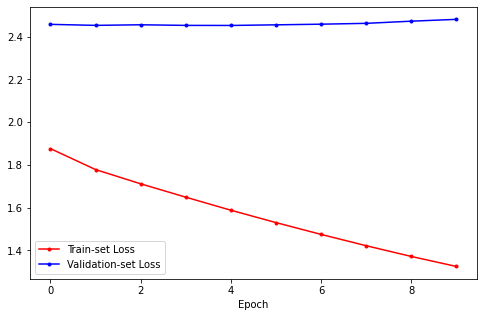

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(hist.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(hist.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [73]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                     reduction='none')

model9.compile(loss=loss, optimizer=optimizer)
#hist = model9.fit(x=enc_train, y=dec_train, epochs=10, batch_size=128, 
#                  validation_data=(enc_val, dec_val))
hist = model9.fit(dataset, validation_data=valset, epochs=10)

Epoch 1/10
487/487 [==============================] - 114s 231ms/step - loss: 3.2969 - val_loss: 2.8731
Epoch 2/10
487/487 [==============================] - 113s 231ms/step - loss: 2.7595 - val_loss: 2.6540
Epoch 3/10
487/487 [==============================] - 113s 232ms/step - loss: 2.4402 - val_loss: 2.5109
Epoch 4/10
487/487 [==============================] - 113s 231ms/step - loss: 2.1717 - val_loss: 2.4126
Epoch 5/10
487/487 [==============================] - 113s 231ms/step - loss: 1.9522 - val_loss: 2.3493
Epoch 6/10
487/487 [==============================] - 113s 231ms/step - loss: 1.7719 - val_loss: 2.3075
Epoch 7/10
487/487 [==============================] - 113s 231ms/step - loss: 1.6227 - val_loss: 2.2826
Epoch 8/10
487/487 [==============================] - 113s 232ms/step - loss: 1.5029 - val_loss: 2.2713
Epoch 9/10
487/487 [==============================] - 113s 232ms/step - loss: 1.4016 - val_loss: 2.2670
Epoch 10/10
487/487 [==============================] - 113s 231m

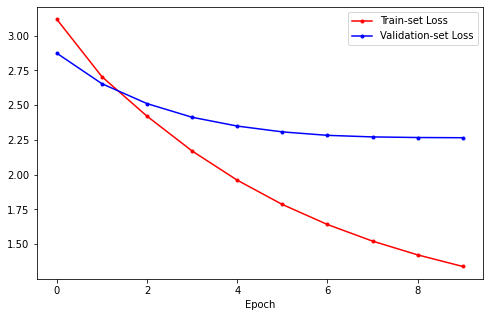

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(hist.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(hist.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Step 5. 인공지능 평가하기

In [75]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [181]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

In [191]:
generate_text(model2, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not a <unk> <end> '

In [196]:
generate_text(model3, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m a <unk> <end> '

In [208]:
generate_text(model4, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love confusing superhero pigs swig chief fakeass fakeass fakeass herc herc troubled troubled troubled troubled vera vera vera '

In [210]:
generate_text(model5, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m a <unk> <end> '

In [18]:
generate_text(model6, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love the way you lie <end> '

In [31]:
generate_text(model7, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you to be a <unk> <end> '

In [35]:
generate_text(model8, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

In [76]:
generate_text(model9, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love the way you lie <end> '

### < 정리 및 회고 >

어떻게 해야 검증셋의 loss를 2.2 수준으로 낮출 수 있을지 다양한 방법을 시도해 보았다. 시도할 때마다 상당한 시간이 소요되어 정말 인내심이 많이 필요한 프로젝트였다. 다양한 방법은 아래와 같다.

- embedding_size 변경
- hidden_size 변경
- batch_size 변경
- learning_rate 변경
- rnn 모델 변경
- 등등...

결국 마지막 model9에서 겨우 2.2수준까지 내려왔다. 각 모델마다 생성한 문장은 비슷하다. 모델9가 생성한 문장은 'i love the way you lie'. '너의 거짓말(하는 방식, 방법) 까지 사랑한다' 정도로 해석하면 괜찮지 않을까 싶다.

모델9은 rnn모델을 2개에서 1개로 줄였다. 마감시간 전까지 제출해야하는데 모델 학습 시간을 조금이라도 줄여보자라는 마음에 시도한 것인다. 이렇게 나와 다행이다.

문장을 전처리하는 과정에서 정규식 등 다양한 방법을 익히게 되었다. 아직 이숙하진 않지만 보다 더 자연스럽게 쓸 수 있도록 반복학습 해야겠다.

자연어처리가 생소하지만 이렇게 처음 접하게 되어 좋았으나 모델 학습시간이 상당하는 점에서 약간의 부담도 느껴진다. 하지만 앞으로 더 자세히 배워보고 싶다.